## Imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tqdm.notebook import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

ImportError: cannot import name 'Input' from 'transformers' (/usr/local/lib/python3.10/dist-packages/transformers/__init__.py)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
df = pd.read_csv('/content/gdrive/MyDrive/ML Project/Womens Clothing E-Commerce Reviews.csv')

## Data Preprocessing

In [22]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

Drop Some Features

In [23]:
df = df.drop(['Unnamed: 0', 'Clothing ID', 'Positive Feedback Count', 'Division Name'], axis=1)

Combine Rating, Age, Department, Class, Title and Review

In [24]:
df['Combined Text'] = df.apply(lambda row: "I rate this item {0} out of 5 stars. My age is {1} years.{2}{3}{4}{5}".format(
    row["Rating"],
    row["Age"],
    f" This item is from the {row['Department Name']} department." if not pd.isna(row['Department Name']) else "",
    f" It falls under the {row['Class Name']} class." if not pd.isna(row['Class Name']) else "",
    f" {row['Title']}." if not pd.isna(row['Title']) else "",
    f" {row['Review Text']}" if not pd.isna(row['Review Text']) else "",
), axis=1)

Lowercase

In [25]:
df['Combined Text'] = df['Combined Text'].str.lower()

In [26]:
df.shape

(23486, 8)

In [27]:
df.head(5)

,Age,Title,Review Text,Rating,Recommended IND,Department Name,Class Name,Combined Text
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,Intimate,Intimates,i rate this item 4 out of 5 stars. my age is 3...
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,Dresses,Dresses,i rate this item 5 out of 5 stars. my age is 3...
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,Dresses,Dresses,i rate this item 3 out of 5 stars. my age is 6...
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Bottoms,Pants,i rate this item 5 out of 5 stars. my age is 5...
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,Tops,Blouses,i rate this item 5 out of 5 stars. my age is 4...


In [28]:
df['Recommended IND'].value_counts(normalize = True)

Recommended IND
1    0.822362
0    0.177638
Name: proportion, dtype: float64

Train-Validation-Test Split

In [29]:
X = df['Combined Text'].values
y = df['Recommended IND'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
  )

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train.shape, X_val.shape, X_test.shape

((16440,), (3523,), (3523,))

## Data Formatting

In [30]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Find Max Token Length

In [31]:
token_length = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length = max(token_length)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [32]:
X_train_tokens = tokenizer(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [33]:
X_val_tokens = tokenizer(
    X_val.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

In [34]:
X_test_tokens = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

## Model Architecture

1. Input Layer:
  * Shape: (max_token_length,)
  * Takes input ids and attention masks.

2. BERT Layer:
  * Pre-Trained BERT model for sequence classification.
  * Produces 'logits' as pooled output.

3. Output Layer:
  * Dense layer with Sigmoid activation function (1 unit).

In [38]:
def create_model():
    input_ids = Input(shape=(max_token_length,), dtype=tf.int32)
    input_ids = input_ids.numpy()
    attention_mask = Input(shape=(max_token_length,), dtype=tf.int32)

    bert_model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased')
    outputs = bert_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    output_layer = Dense(1, activation='sigmoid')(pooled_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

Training Parameters (Recommended in BERT Paper published by Google):
* Optimizer: Adam
* Learning Rate: 2e-5
* Epochs: 4
* Batch Size: 32

In [39]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

AttributeError: 'KerasTensor' object has no attribute 'numpy'

In [ ]:
history = model.fit(
    [X_train_tokens['input_ids'], X_train_tokens['attention_mask']],
    y_train,
    epochs=4,
    batch_size=32,
    validation_data=([X_val_tokens['input_ids'], X_val_tokens['attention_mask']], y_val),
)

Epoch 1/4
514/514 [==============================] - 760s 1s/step - loss: 0.1773 - accuracy: 0.9268 - val_loss: 0.1186 - val_accuracy: 0.9512
Epoch 2/4
514/514 [==============================] - 754s 1s/step - loss: 0.1169 - accuracy: 0.9518 - val_loss: 0.1174 - val_accuracy: 0.9489
Epoch 3/4
514/514 [==============================] - 756s 1s/step - loss: 0.0872 - accuracy: 0.9663 - val_loss: 0.1288 - val_accuracy: 0.9554
Epoch 4/4
514/514 [==============================] - 752s 1s/step - loss: 0.0518 - accuracy: 0.9816 - val_loss: 0.1773 - val_accuracy: 0.9489


Save Weights

In [ ]:
model.save_weights('/content/gdrive/MyDrive/ML Project/Weights/BERT Base (Recommended IND).h5')

## Evaluation

Load Saved Weights

In [ ]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.load_weights('/content/gdrive/MyDrive/ML Project/Weights/BERT Base (Recommended IND).h5')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 201)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 201)]                0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094837   ['input_3[0][0]',             
 ification_1 (TFBertForSequ  (loss=None, logits=(None,    78         'input_4[0][0]']             
 enceClassification)         2),                                                                  
                              hidden_states=None, atten                                     

In [ ]:
y_pred = model.predict([X_test_tokens['input_ids'], X_test_tokens['attention_mask']])
y_pred_binary = (y_pred > 0.5).astype(int)

111/111 [==============================] - 53s 437ms/step


In [ ]:
accuracy_score(y_test, y_pred_binary)

0.9457848424638092

In [ ]:
precision_score(y_test, y_pred_binary)

0.9592668024439919

In [ ]:
recall_score(y_test, y_pred_binary)

0.9754918881601657

In [ ]:
f1_score(y_test, y_pred_binary)

0.9673113126818416

In [ ]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       626
           1       0.96      0.98      0.97      2897

    accuracy                           0.95      3523
   macro avg       0.92      0.89      0.90      3523
weighted avg       0.94      0.95      0.94      3523



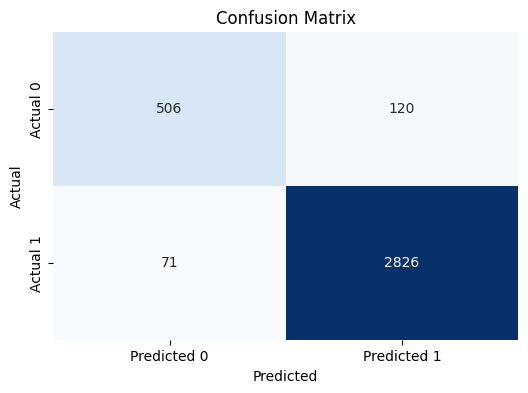

In [ ]:
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()